Skin cancer is the most common human malignancy, is primarily diagnosed visually, beginning with an initial clinical screening and followed potentially by dermoscopic analysis, a biopsy and histopathological examination. Automated classification of skin lesions using images is a challenging task owing to the fine-grained variability in the appearance of skin lesions.

This the **HAM10000 ("Human Against Machine with 10000 training images")** dataset.It consists of 10015 dermatoscopicimages which are released as a training set for academic machine learning purposes and are publiclyavailable through the ISIC archive. This benchmark dataset can be used for machine learning and for comparisons with human experts. 

It has 7 different classes of skin cancer which are listed below :<br>
**1. Melanocytic nevi <br>**
**2. Melanoma <br>**
**3. Benign keratosis-like lesions <br>**
**4. Basal cell carcinoma <br>**
**5. Actinic keratoses <br>**
**6. Vascular lesions <br>**
**7. Dermatofibroma<br>**

<img src = "https://miiskin.com/wp-content/uploads/2019/08/types-of-skin-cancer-700x514.jpg">

#### Imports Done!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
import plotly.express as px


import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# 1. Exploratory Data Analysis

In [2]:
## Kernal Ref - https://www.kaggle.com/kmader/dermatology-mnist-loading-and-processing
base_skin_dir = os.path.join('..', 'input/skin-cancer-mnist-ham10000/')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
skin_data = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

In [4]:
skin_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
skin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [6]:
skin_data['path'] = skin_data['image_id'].map(imageid_path_dict.get)
skin_data['cell_type'] = skin_data['dx'].map(lesion_type_dict.get) 
skin_data['cell_type'] = pd.Categorical(skin_data['cell_type'])
skin_data['cell_type_idx'] = pd.Categorical(skin_data['cell_type']).codes


In [7]:
skin_data.isna().sum()
skin_data['age'] = skin_data['age'].fillna(skin_data['age'].median())

In [8]:
skin_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2


In [9]:
tmp = skin_data['cell_type'].value_counts()
tmp = tmp.reset_index()
tmp.columns = ['Classes','count']
fig = px.bar(tmp, x="Classes", y="count", color='Classes')
fig.show()

In [10]:
tmp = skin_data['sex'].value_counts()
tmp = tmp.reset_index()
tmp.columns = ['sex','count']
fig = px.pie(tmp, values='count', names='sex')
fig.show()

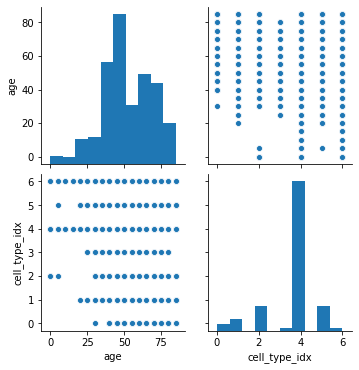

In [11]:
sns.pairplot(skin_data)

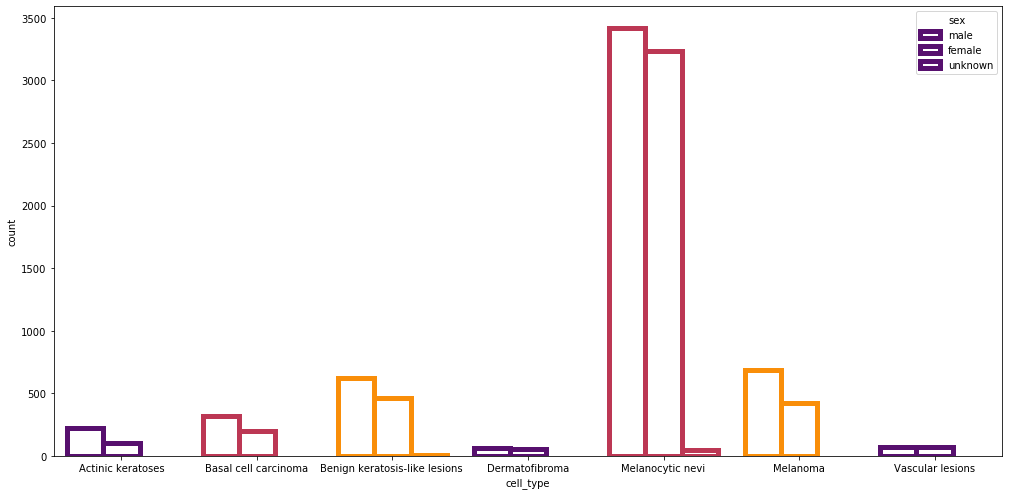

In [12]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 17.0,8.27
sns.countplot(x="cell_type", hue="sex", data=skin_data,facecolor=(0, 0, 0, 0),
                   linewidth=5,
                   edgecolor=sns.color_palette("inferno", 3))

In [13]:
from skimage.io import imread
skin_data['image'] = skin_data['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [14]:
skin_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,"[[[136, 91, 114], [148, 104, 127], [161, 117, ..."


# 2. Data Preprocessing

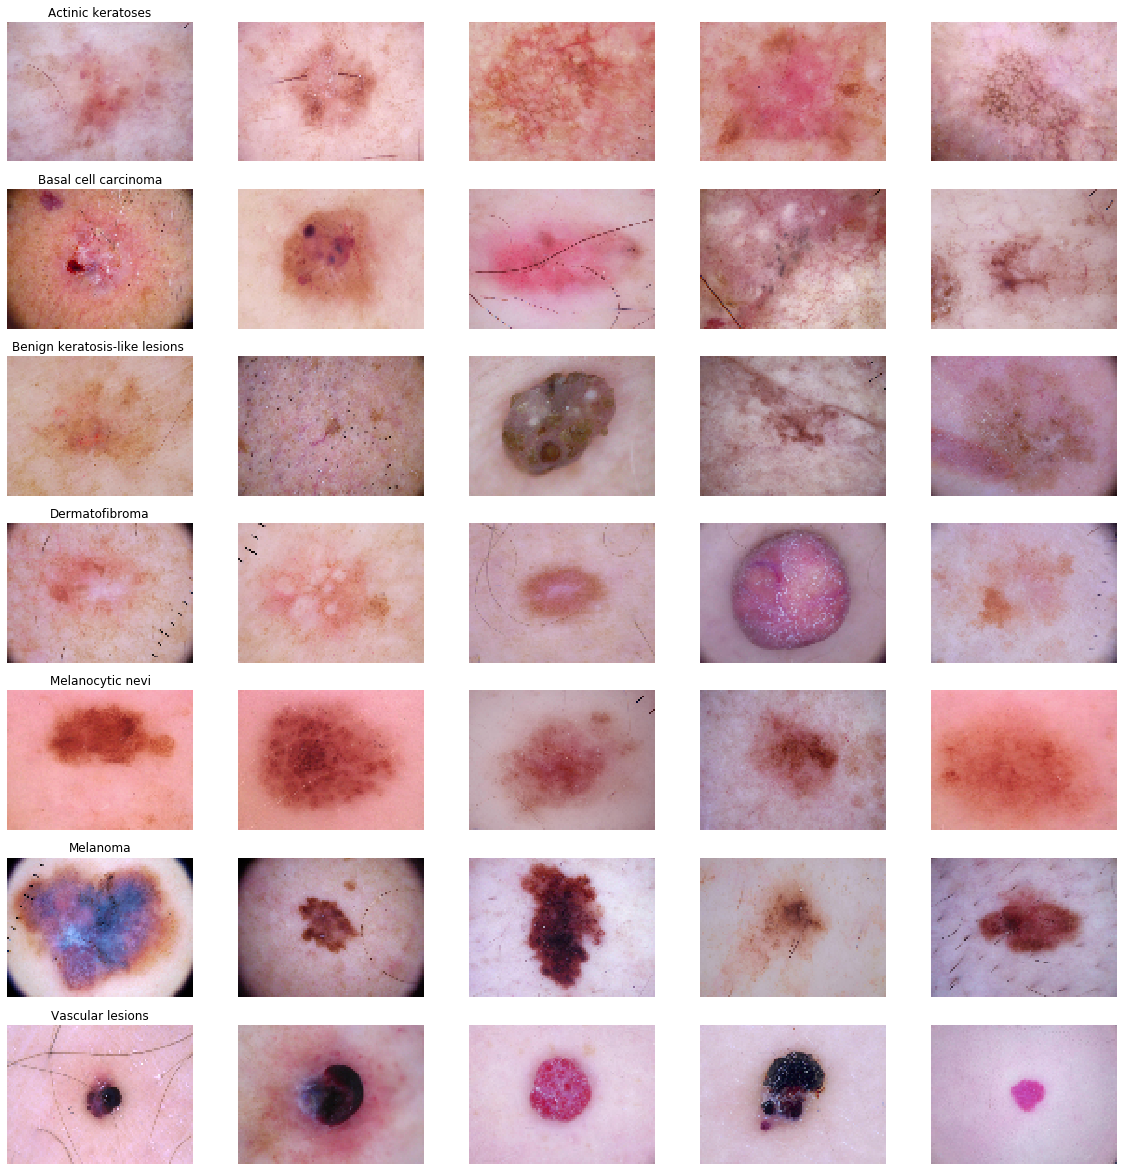

In [15]:
n_samples=5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,skin_data.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [16]:
features=skin_data.drop(columns=['cell_type_idx'],axis=1)
label=skin_data['cell_type_idx']

In [17]:
Xtrain, X_test, y_train, y_test = train_test_split(features, label, test_size=0.20,random_state=42)

In [18]:
x_train = np.asarray(Xtrain['image'].tolist())
x_test = np.asarray(X_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [19]:
# Let's confirm the number of classes :p
no_of_classes = len(np.unique(y_train))
no_of_classes

7

In [20]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train,no_of_classes)
y_test = np_utils.to_categorical(y_test,no_of_classes)
y_train[0] 

array([0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [21]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_valid = x_valid.reshape(x_valid.shape[0], *(75, 100, 3))

In [22]:
x_train = x_train.astype('float32')/255
x_valid = x_valid.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train[0]

array([[[ 6.9707641e-03,  8.5137744e-04,  1.6058224e-03],
        [ 7.1384180e-03,  5.9989578e-04,  1.6896495e-03],
        [ 6.9707641e-03,  5.1606860e-04,  1.8573040e-03],
        ...,
        [ 6.5516280e-03, -2.3837631e-04,  1.0190319e-03],
        [ 6.3839736e-03,  9.6932541e-05,  6.8372302e-04],
        [ 6.2163188e-03,  1.3105328e-05,  1.1028592e-03]],

       [[ 7.4737272e-03,  9.3520468e-04,  2.1087858e-03],
        [ 6.8869367e-03,  7.6755020e-04,  1.6896495e-03],
        [ 7.1384180e-03,  7.6755020e-04,  1.7734768e-03],
        ...,
        [ 6.4678006e-03,  9.6932541e-05,  9.3520468e-04],
        [ 6.0486645e-03, -3.2220350e-04,  6.8372302e-04],
        [ 6.2163188e-03, -1.5454910e-04,  8.5137744e-04]],

       [[ 6.8031098e-03,  4.3224139e-04,  1.2705135e-03],
        [ 7.2222459e-03,  5.9989578e-04,  2.1926127e-03],
        [ 7.0545911e-03,  6.8372302e-04,  1.7734768e-03],
        ...,
        [ 6.3839736e-03, -1.5454910e-04,  1.1866863e-03],
        [ 6.3001462e-03,  1.8

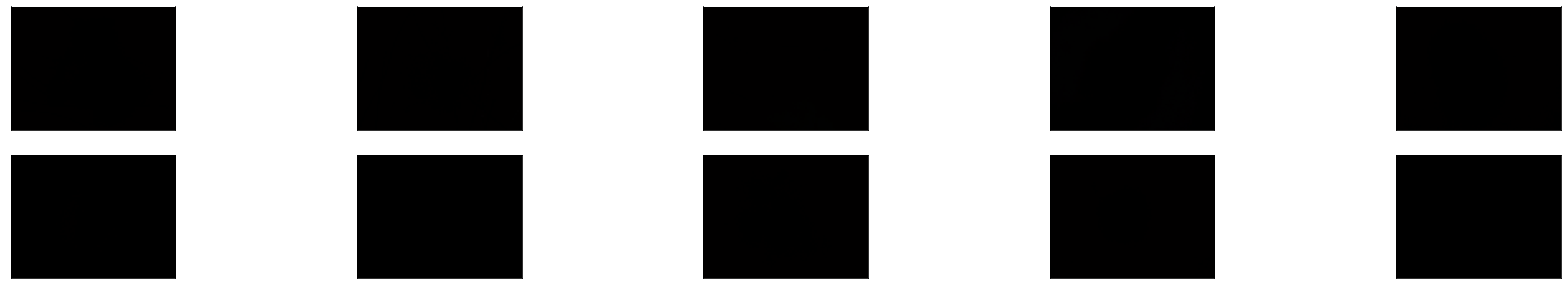

In [23]:
fig = plt.figure(figsize =(30,5))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

# 3. Model Build

In [24]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 2,input_shape=(75,100,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 32,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 64,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 128,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(150))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(7,activation = 'softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 100, 16)       208       
_________________________________________________________________
activation_1 (Activation)    (None, 75, 100, 16)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 50, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 50, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 25, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 25, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 12, 64)        

In [25]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [26]:
batch_size = 32

checkpointer = ModelCheckpoint(filepath = 'model.hdf5', verbose = 1, save_best_only = True)

history = model.fit(x_train,y_train,
        batch_size = 32,
        epochs=30,
        validation_data=(x_valid, y_valid),
        callbacks = [checkpointer],
        verbose=2, shuffle=True)

Train on 7210 samples, validate on 802 samples
Epoch 1/30
 - 5s - loss: 1.1654 - accuracy: 0.6705 - val_loss: 1.1830 - val_accuracy: 0.6434

Epoch 00001: val_loss improved from inf to 1.18297, saving model to model.hdf5
Epoch 2/30
 - 2s - loss: 1.0286 - accuracy: 0.6717 - val_loss: 1.0970 - val_accuracy: 0.6434

Epoch 00002: val_loss improved from 1.18297 to 1.09701, saving model to model.hdf5
Epoch 3/30
 - 2s - loss: 0.9521 - accuracy: 0.6706 - val_loss: 1.1500 - val_accuracy: 0.6446

Epoch 00003: val_loss did not improve from 1.09701
Epoch 4/30
 - 2s - loss: 0.9140 - accuracy: 0.6831 - val_loss: 0.9910 - val_accuracy: 0.6446

Epoch 00004: val_loss improved from 1.09701 to 0.99100, saving model to model.hdf5
Epoch 5/30
 - 2s - loss: 0.8973 - accuracy: 0.6968 - val_loss: 1.0377 - val_accuracy: 0.6409

Epoch 00005: val_loss did not improve from 0.99100
Epoch 6/30
 - 2s - loss: 0.8809 - accuracy: 0.6908 - val_loss: 0.9913 - val_accuracy: 0.6496

Epoch 00006: val_loss did not improve from

In [27]:
model.load_weights('model.hdf5')
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.7324013710021973


# 4.Predictions

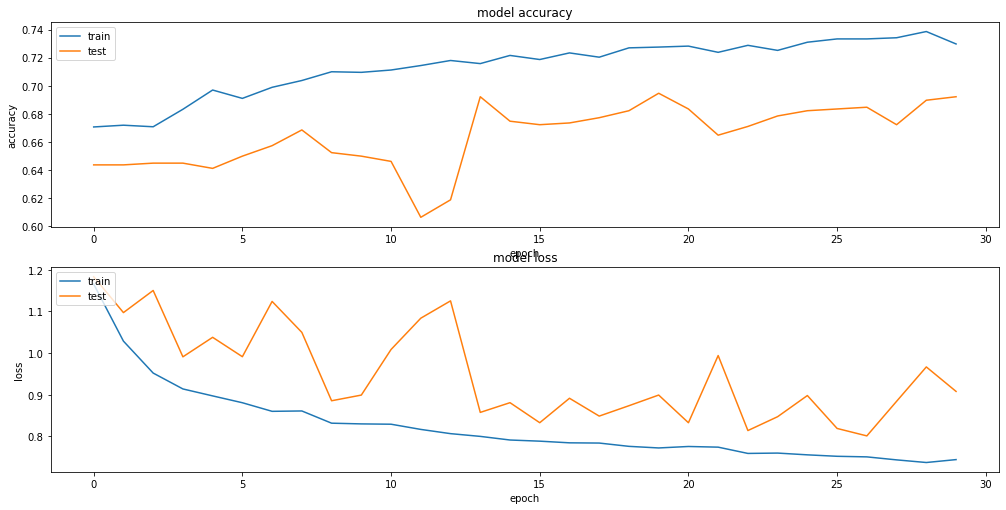

In [28]:
plt.figure(1)  
   
 # summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

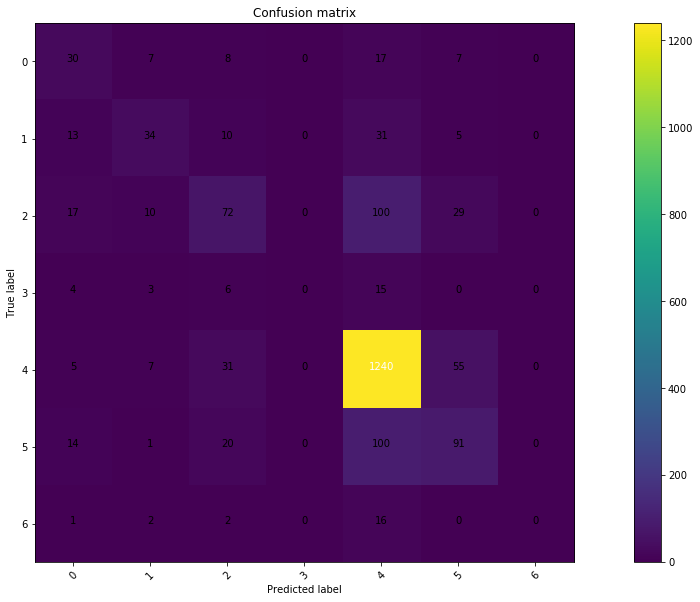

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

<b> Streamlit App for Skin cancer Analyzer on my Github </b> <br>

### [Github](https://github.com/shashwatwork/Skin-cancer-Analyzer) <br> <br>
## Demo Application Available [here](https://skin-cancer-analysis.herokuapp.com/)

### Don't hesitate to Upvote if You like this kernal !!!!

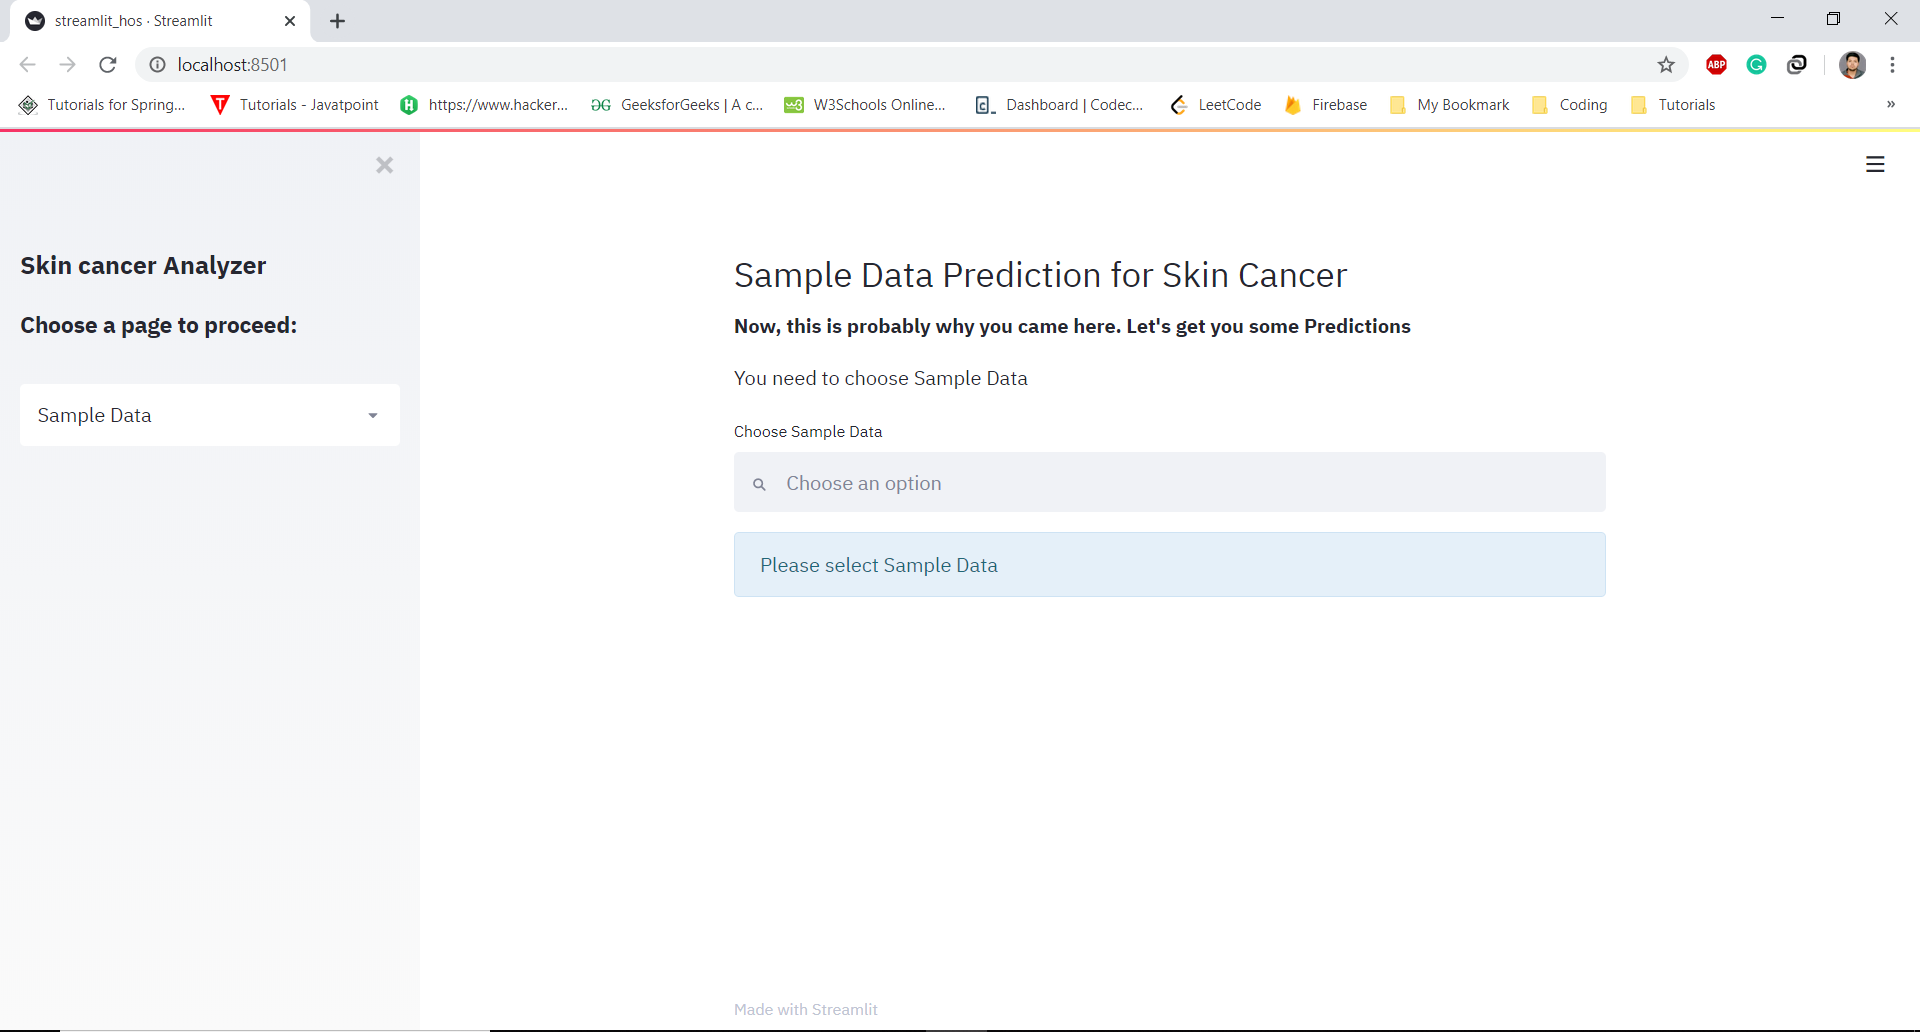